**[UNFINISHED]**

This notebook was created on 1/19/22

See example notebook for creating superclassed ImageNet: https://github.com/MadryLab/robustness/blob/master/notebooks/Superclassing%20ImageNet.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import special

from utils.imagenet_helpers import ImageNetHierarchy

%load_ext autoreload
%autoreload 2

# Create superclassed ImageNet dataset

### 1. Create superclasses

In [2]:
num_superclasses = 20

hier_info_path = 'data/imagenet_hierarchy/'
in_hier = ImageNetHierarchy(hier_info_path)

In [4]:
in_hier.wnid_sorted

[('n00001740', 1000, 1819),
 ('n00001930', 992, 1784),
 ('n00002684', 946, 1680),
 ('n00003553', 936, 1657),
 ('n00021939', 521, 949),
 ('n00004258', 407, 683),
 ('n00004475', 407, 682),
 ('n00015388', 398, 663),
 ('n03575240', 348, 617),
 ('n01466257', 207, 389),
 ('n01471682', 207, 388),
 ('n03183080', 121, 227),
 ('n01317541', 121, 157),
 ('n02084071', 116, 150),
 ('n01861778', 95, 163),
 ('n03094503', 94, 134),
 ('n01886756', 89, 150),
 ('n03076708', 62, 114),
 ('n03093574', 61, 108),
 ('n01905661', 61, 97),
 ('n02087122', 61, 78),
 ('n04341686', 55, 100),
 ('n01503061', 52, 98),
 ('n03051540', 48, 86),
 ('n01767661', 47, 73),
 ('n00020827', 43, 90),
 ('n04576211', 42, 56),
 ('n03122748', 38, 71),
 ('n03294048', 38, 63),
 ('n01661091', 36, 71),
 ('n02075296', 35, 47),
 ('n03563967', 33, 63),
 ('n01661818', 31, 61),
 ('n02103406', 30, 38),
 ('n04170037', 30, 38),
 ('n03574816', 28, 57),
 ('n02159955', 27, 43),
 ('n03100490', 26, 51),
 ('n03800933', 26, 41),
 ('n02092468', 26, 31),
 

In [5]:
in_hier.get_node("n00001740")

Name: (entity), ImageNet Class: (-1), Descendants: (1000)

In [7]:
# for cnt, (wnid, ndesc_in, ndesc_total) in enumerate(in_hier.wnid_sorted):
#     if cnt < 10:
#         print(f"WordNet ID: {wnid}, Name: {in_hier.wnid_to_name[wnid]}, #ImageNet descendants: {ndesc_in}")

In [157]:
superclass_wnid, class_ranges, label_map = in_hier.get_superclasses(num_superclasses,
                                           ancestor_wnid='n00001740',
                                           superclass_lowest=['n02084071'],
                                           balanced=False)

BEFORE: ['physical entity']
AFTER: ['physical entity']
BEFORE: ['physical entity', 'object, physical object']
AFTER: ['object, physical object']
BEFORE: ['object, physical object', 'whole, unit']
AFTER: ['whole, unit']
BEFORE: ['whole, unit', 'artifact, artefact']
AFTER: ['artifact, artefact']
BEFORE: ['artifact, artefact', 'living thing, animate thing']
AFTER: ['artifact, artefact', 'living thing, animate thing']
BEFORE: ['artifact, artefact', 'living thing, animate thing', 'organism, being']
AFTER: ['artifact, artefact', 'organism, being']
BEFORE: ['artifact, artefact', 'organism, being', 'animal, animate being, beast, brute, creature, fauna']
AFTER: ['artifact, artefact', 'animal, animate being, beast, brute, creature, fauna']
BEFORE: ['artifact, artefact', 'animal, animate being, beast, brute, creature, fauna', 'instrumentality, instrumentation']
AFTER: ['animal, animate being, beast, brute, creature, fauna', 'instrumentality, instrumentation']
BEFORE: ['animal, animate being, beas

In [158]:
# Sanity checks
num_classes_per_superclass = [len(x) for x in class_ranges]
print(num_classes_per_superclass)

[116, 55, 38, 35, 33, 31, 28, 27, 26, 24, 24, 24, 23, 21, 21, 21, 21, 20, 19, 17]


In [159]:
print(f'Only {sum(num_classes_per_superclass)} out of 1000 classes are included in a superclass')

Only 624 out of 1000 classes are included in a superclass


Weirdly, the sum is not 1000 like I expected. It seems like some classes are not included in the superclasses 

In [135]:
for i in range(len(superclass_wnid)):
    print(f'Superclass {i}: {in_hier.wnid_to_name[superclass_wnid[i]]}')
    # Print names of subclasses
    s = ', '.join([in_hier.num_to_name[j] for j in class_ranges[i]]) 
    print('  subclasses:', s[:-1], '\n')
    

Superclass 0: device
  subclasses: cornet, crane, desktop_computer, digital_clock, digital_watch, disk_brake, drum, electric_fan, electric_guitar, flute, French_horn, gas_pump, gong, grand_piano, guillotine, hair_slide, hand-held_computer, hard_disc, harmonica, harp, harvester, hook, hourglass, jack-o'-lantern, knot, laptop, lighter, loudspeaker, loupe, magnetic_compass, maraca, marimba, maypole, microphone, missile, mouse, mousetrap, muzzle, nail, neck_brace, notebook, oboe, ocarina, odometer, oil_filter, organ, oxygen_mask, paddlewheel, padlock, panpipe, parking_meter, pick, pier, pinwheel, potter's_wheel, power_drill, projectile, projector, radiator, radio_telescope, reel, remote_control, revolver, rifle, rule, safety_pin, sax, scale, screen, screw, ski, slide_rule, slot, snorkel, solar_dish, space_heater, spider_web, spotlight, steel_drum, stethoscope, stopwatch, stove, strainer, sundial, sunglass, sunglasses, switch, syringe, thresher, torch, tripod, trombone, typewriter_keyboard,

### 2.  Compute softmax scores and labels
This involves (a) Adding together softmax scores for classes in the same superclass and (b) Mapping class labels to the correct superclass 

In [160]:
## Read in logits and labels from ImageNet-val

logits = torch.load('data/imagenet_val/logits.pt')
labels = torch.load('data/imagenet_val/labels.pt')

n = len(labels)

# Convert to Numpy arrays
logits = logits.numpy()
labels = labels.type(torch.LongTensor).numpy()

# Compute softmax vectors
softmax_scores = special.softmax(logits, axis=1)

In [161]:
# Create map of original ImageNet class to the superclass it belongs to
class_to_superclass = {}
for superclass, classes in enumerate(class_ranges):
    for c in classes:
        class_to_superclass[c] = superclass

In [162]:
superclassed_softmax_scores = np.zeros((n, num_superclasses))

# (a): Sum softmax scores
for i in range(num_superclasses):
    superclassed_softmax_scores[:, i] = np.sum(softmax_scores[:, list(class_ranges[i])], axis=1)
#     print(superclassed_softmax_scores[4])

# (b): Map labels to superclasses
superclassed_labels = np.zeros((n,))

not_in_superclasses = []
for i, label in enumerate(labels):
    if label not in class_to_superclass:
        not_in_superclasses.append(label)
#     superclassed_labels[i] = class_to_superclass[label]


print(f'{len(not_in_superclasses)} examples are not included in any superclass')

18800 examples are not included in any superclass


In [69]:
np.sum(softmax_scores[3,:])

1.0000004

In [107]:
np.sum(superclassed_softmax_scores[100,:])

2.1737530012111428e-07

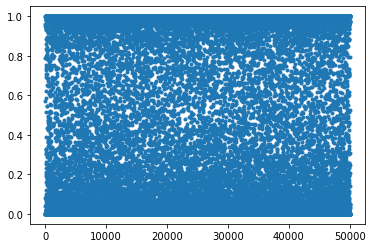

In [113]:
plt.plot(np.sum(superclassed_softmax_scores, axis=1), '.')

In [112]:
np.sum(superclassed_softmax_scores, axis=1)

array([9.99709858e-01, 9.67162127e-09, 7.58073305e-05, ...,
       3.36472970e-02, 9.96379593e-01, 9.99653856e-01])